<font face="Verdana, cursive, sans-serif" >
<h1><center>Creating stock sentiment index from company news</center></h1>

<b>Author: Siraprapa Watakit</b>
<br><b>Last edited: March 2019</b>
<p><b>Synopsis:</b></p>

<p>This python notebook is a part of a working paper <b>"The Public and Private Life of Big Data",Pavabutr and Watakit(2018)</b>. This notebook demonstrates a step-by-step sentiment index creation from company news. </p>

<p>The following libraries are required for the project</p>
<ul>
   <li><code>panda,numpy</code>&nbsp; For dataframe, vector and matrix processing</li>
   <li><code>BeautifulSoup</code> &nbsp;  For HTML data parsing</li>
   <li><code>nltk,corpus</code> &nbsp; For nature language processing </li>
   <li><code>matplotlib,wordcloud</code> &nbsp; For data visulization </li>
</ul>


<p>Note that <code>nltk,corpus</code> has to be installed manually. Please refer to <code>Anaconda</code> or <code>pip</code> installation manaul </p>

<p><b>Disclaimer:</b>This material is for informational and educational purposes only. </p>



<font face="Verdana, cursive, sans-serif" >
<h2>What is natural language processing?</h2>


<p>Natural language processing is a sub field of computer science. The purpose of this sub-field is to make computers understand human language so that it can performance certain tasks. Example of applications of NLP are document summarisation, translation, chatbots and sentimental analysis. In order to make computer understand human language, the language must be convert to a sequence of binary (0,1). General NLP methodology involves (1) Lexical analysis: convert sentence to tokens, (2) Syntactic analysis: analyse and understand grammar structure and relationship between token, (3) Interpreting the meaning of a sentence; which require machine learning or deep learning methodologies. In this program, we specifically show simple tasks of natural language processing for sentiment analysis, step-by-step.</p>

<h2>What is sentiment analysis?</h2>
<p>Sentiment analysis is a process of gauging general opinion toward a certain topic. Sentiment analysis process usually involves aggregating freetext data and determines whether this freetext data is good sentiment or bad sentiment. The purpose of this program is to gently introduce reader to NLP and sentiment analysis by demonstrating an end-to-end process from data preparation -to- model creation -to- model excecution. Therefore, the following guidelines are by no means exhaustive.  </p>
<ol>
   <li>Identify credible source and extract the data from the source</li>
   <li>Data preparation: cleaning, remove stopwords, remove non-alphabetic characters, normalize charecter case to either lower or upper.</li>
    <li>Tokenization: convert a sentence to a vector of word</li>
    <li>Create a dictionary from vector of word</li>
    <li>Create a feature matrix</li>
    <li>Build and train model from feature matrix</li>
    <li>Score new data with the model</li>
</ol>

<p>We have a initial of 5,462 top-story news(Reuters) of SET50 stocks during (Jan/2014-Jun/2018). We remove irrelevant and duplicate news, and manually categorize news into 3 groups: good news, bad news, and neutral. In our final selection, we have a total of 1,914 news: 527(good), 262(bad), 1,125(neutral).<br> <br>Good news is represented by '1' and bad news is presented by '0' in our dataset</p>

<br>Guidelines 2-5 can be illustrated as follows:

<img src="./images/nlp_process_1.png" >
<p><i>The above figure is for illustration only, index in python starts at 0</i>
<p>Where <b>N</b> is the total number of news and <b>D</b> is the total number of words  

<p>Note that each numeric represents existence of words in documents. It can be calculated in various ways; among the commonly known are</p>

<ul>
    <li>Word count: each numeric is a total count of appearance of each word in a document</li>
    <li>Word proportion : each numeric is a % of a word / total word in a document</li>
    <li>Term frequnecy inverse document frequency(TF-IDF): each numeric represent an importaness of a word in a document relative to other words in the whole collection of documents.</li>
</ul>

In the next section, we demonstrate a step-by-step programming in 2 approach:

<ul>
    <li>Apporach 1 Longhand Programming, starting from the scratch until modeling</li>
    <li>Apporach 2 Shorthand Programming, demonstraing the utilization of python library</li>
</ul>


<font face="Verdana, cursive, sans-serif">
<h1><b><center>Approach 1 Longhand Programming</center></b></h1>

<b>Feature matrix : Word Proportion</b>


<font face="Verdana, cursive, sans-serif">
<b>Step 1 Import libraries</b>


In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import string
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from custom_functions import print_classification_performance2class_report

<font face="Verdana, cursive, sans-serif">
<b>Step 2 Prepare stopword list and define utility functions </b>
<p><b>stopwords</b> are words which have no sentiment meaning such "as is, am, are,a ,an ,the". These words must be removed in order to minimise the size of feature matrix.</p>
<p>
<ul>
    <li><code>text_preprocess_tokenizer()</code> this function pre-process a sentence, clean it and tokenize it </li>
    <li><code>tokens_to_vector()</code> this function convert all tokens to vectors</li>
    <li><code>visualize()</code> wordcloud visulization tool</li>
</ul>

In [2]:
#prepare stopwords
#import stopwrds from nltk, and add some more
stopwords = set(stopwords.words("english"))
stocklists = set(w.rstrip().lower()+'.bk' for w in open('./input/tickersSET.csv',encoding="utf8"))
stopwords = stopwords.union(stocklists)
stopwords = stopwords.union({'bangkok','thailand','reuters','thomson reuters','ptt','pcl','banpu','baht','said','central','karnchang','plaza','passenger','pattana'
                             ,'airport','charoen','pokphand','hotel','tourism','assurance','life','sophonpanich','chatri','dusit','food','choedchu','airway','mhz','advanced','info','medical','hospital'
                             ,'bts','mayo','polyclinic','thai','percent','company','million','billion','share','year','bank','italian','petrochemical'})


# preprocess text : clean/remove/convert a text to a list of token
def text_preprocess_tokenizer(s):
    wordnet_lemmatizer = WordNetLemmatizer()
    s = s.lower()                              #1 lower it all
    s = s.replace('buzz-','')                  #2 remove reuters keywords
    s = s.replace('brief-','')                 
    s = s.replace('update-1','')               
    s = s.replace('corrected-','')  
    s = s.replace('full story','')
    s = ''.join([i for i in s if not i.isdigit()])  #3 remove digit    
    s = ''.join([i for i in s if s not in string.punctuation]) #4 remove punctuation
    tokens = nltk.tokenize.word_tokenize(s)         #5 tokennize it
    tokens = [t for t in tokens if len(t)>3]        #6 keep only words length>3
    tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens]  #7 lemmatize it, return a word to its basic form
    tokens = [t for t in tokens if t not in stopwords]          #8 remove stopwords
    return tokens

word_index_map = {}
current_index = 0

#convert word tokens to feature vector: propoertion method
def tokens_to_vector(tokens,label):
    x=np.zeros(len(word_index_map)+1)
    for t in tokens:
        i = word_index_map[t]
        x[i] += 1
    x = x/x.sum() 
    x[-1] = label
    return x

# visualize the data
def visualize(data,title):
  words = ''
  for row in data:
      for msg in row:
          words += msg + ' '
  wordcloud = WordCloud(width=600, height=400).generate(words)
  plt.imshow(wordcloud)
  plt.title("{}".format(title))
  plt.axis('off')
  plt.show()


<font face="Verdana, cursive, sans-serif">
<b>Step 3 Data pre-posessing, tokensizing and dictionary creation</b>
<p>In this step, we iterate through each news item: pre-process it, tokenize it, as well as building up a dictionary; all at the same time. <br>Note that <code>word_index_map</code> is the <b>dictionary</b>, which will be used to create feature matrix in the next step.

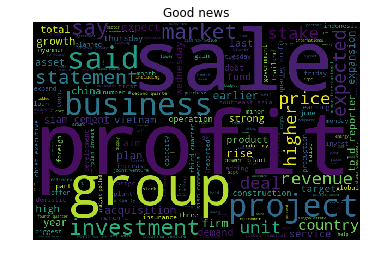

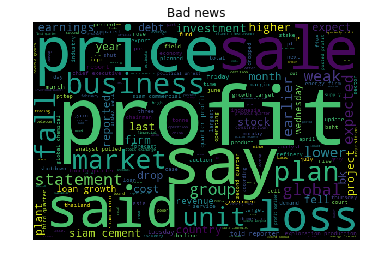

In [3]:
#%% Data preparation
news = pd.read_csv("./input/rtnews_topstory_labeled.csv",sep="|")
news['fulltext'] = news['title']+news['body']
news = news.drop_duplicates(subset=['fulltext'],keep='last')
news = news[(news['label']==1) | (news['label']==0) ]
goodnews = news[news['label']==1]['fulltext'].tolist()
badnews = news[news['label']==0]['fulltext'].tolist()

#tokenized string
goodnews_tokenized = []
badnews_tokenized = []

for news in goodnews:
    tokens = text_preprocess_tokenizer(news)
    goodnews_tokenized.append(tokens)
    for token in tokens:
        if token not in word_index_map:
            word_index_map[token]=current_index
            current_index+=1

for news in badnews:
    tokens = text_preprocess_tokenizer(news)
    badnews_tokenized.append(tokens)
    for token in tokens:
        if token not in word_index_map:
            word_index_map[token]=current_index
            current_index+=1

#let's see what stands out in good news and bad news
visualize(goodnews_tokenized,"Good news")
visualize(badnews_tokenized,"Bad news")

<font face="Verdana, cursive, sans-serif">
<b>Step 4 Create feature matrix</b>
<p>Convert tokenized vectors to feature matrix. Note that this feature matrix is also called "bag-of-words" or "term-document" matrix.
<p><font color='blue'>We will show how to create different types of bag-of-words with python libraries in the later section</font>

In [4]:
#%% Create a feature matrix.
N = len(goodnews_tokenized) + len(badnews_tokenized)
data = np.zeros((N, len(word_index_map) + 1)) 
i = 0
for tokens in goodnews_tokenized:
    xy = tokens_to_vector(tokens, 1)
    data[i,:] = xy
    i += 1

for tokens in badnews_tokenized:
    xy = tokens_to_vector(tokens, 0)
    data[i,:] = xy
    i += 1

<font face="Verdana, cursive, sans-serif">
<b>Step 5 Create train and test feature matric</b>
<p>We utiliize the following libaries to 
 <ul>
    <li><code>sklearn.model_selection.train_test_split</code> to randomly split the feature matric into a train and test matric</li>
     <li><code>sklearn.metrics.classification_report,sklearn.metrics.classification_report </code> to print out the model performance report</li>
</ul>

In [5]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

X = data[:,:-1] # X is everyhting, except last column
y = data[:,-1]  # y is the last column.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234,stratify=y)

#helpers, to keep all metrics for comparison
list_model=[]
list_desc=[]
list_acc = []
list_pc = []
list_rc = []
list_fs = []
list_ap = []
list_roc_auc = []
list_gini = []
i=0

<font face="Verdana, cursive, sans-serif">
<b>Step 6 Build a model</b>

<p><b>To learn more about machine learning, please refer to  <a href="http://scikit-learn.org/stable/index.html">Scikit-Learn: Machine Learning in Python</a></b>

<p><font color="red"><b>Logistic Regression</b></font>


Logistic regression
Accuracy:70.14%
Precision:78.49%
Recall:76.04%
Fscore:77.25%
Average precision:75.66%


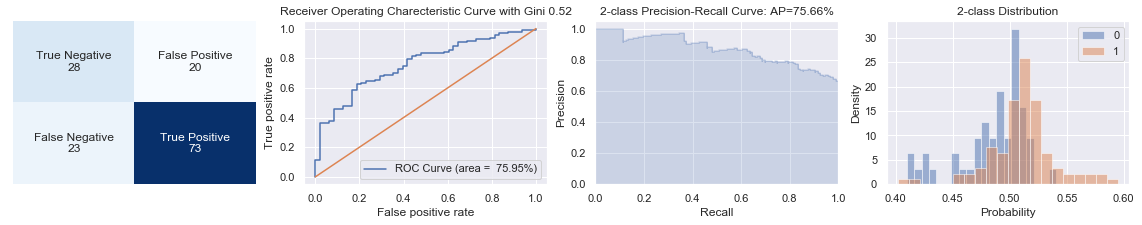

In [6]:
#%% model-1: Logistic regression
from sklearn.linear_model import LogisticRegression
model_logit = LogisticRegression(class_weight="balanced", solver='liblinear')
model_logit.fit(X_train,y_train)
y_pred_model_logit = model_logit.predict(X_test)
y_prob_model_logit = model_logit.predict_proba(X_test)
print("\nLogistic regression")
print("="*20)
acc,pc,rc,fs,ap,roc_auc,gini,prd = print_classification_performance2class_report(model_logit,X_test,y_test)

In [7]:
i+=1
list_model.append('Model_{}'.format(i))
list_desc.append('Word Proportion /w Logistic Regression')
list_acc.append(acc)
list_pc.append(pc)
list_rc.append(rc)
list_fs.append(fs)
list_ap.append(ap)
list_roc_auc.append(roc_auc)
list_gini.append(gini)

<font face="Verdana, cursive, sans-serif">

<img src="./images/confuse.png" >

<b>Interpretation</b>
<ul>
    <li><b>Accuracy</b> measurse an overall performance of the model. How well a model correctly classifies true positive and true negative.</li>
    <li><b>Precision</b> measures how precisely a model idenitifies true positive as actual true positive.<br>[TP / (TP + FP)]</li>
    <li><b>Recall(true positive rate or sensitivity)</b> measures how well a model captures all actual true positive.<br>[TP / (TP + FN))]</li>
    <li><b>F1-Score</b> Harmonic mean of (Precision, Recall)</li>
</ul>


<p>That is, the logistic regression accuracy is 70.14%. It correctly identifies good news 78.49% of the time, it captures 76.04% of all the good news in the <b>test dataset</b>.


<p><b>Estimates Vectors</b>
<p>Each column index represents each word in the feature matic. Similar to any logistic regression problem, the estimated coefficient suggest the impact of each feature to the likelihood of p(y=1|x1,x2,x3..) 

In [8]:
#%% top keywords by model
threshold = 0.05
word_list = []
weight_list = []
for word, index in word_index_map.items():
    weight = model_logit.coef_[0][index]
    if weight > threshold or weight < -threshold:
        word_list.append(word)
        weight_list.append(weight)
        
wordweight = pd.DataFrame(data=[word_list,weight_list])
wordweight = wordweight.transpose()
wordweight.columns = ['word','weight']
wordweight = wordweight.sort_values(by='weight',ascending=False)
print("\nTop words associated with good news")
print(wordweight.head(10))
print("\nTop words associated with bad news")
print(wordweight.tail(10))


Top words associated with good news
             word    weight
233      contract  0.833956
32         invest  0.624893
238        signed   0.62047
101  construction  0.507207
79    development  0.506849
129         stake  0.482122
76           plan  0.440677
237      purchase  0.426541
78        project  0.411618
235          sign  0.395317

Top words associated with bad news
            word    weight
371     shutdown  -0.39392
369         irpc -0.405281
160       versus -0.435823
357        court -0.437232
208   production -0.568917
409  exploration -0.581685
189         drop -0.681355
280         fall -0.866159
0         profit  -1.02193
191         loss  -1.09974


<font face="Verdana, cursive, sans-serif">
<p>For each news item, the proabability of being a good news is calculated by the following equation
<img src="./images/logit_prob.png" >
where beta is the intercept term and alpha(s) are the weights of features<p>(aka coefficients/estimates of variables/parameters in stats-terms )

<p><font color="red"><b>Decision Tree</b></font>


Decision tree
Accuracy:77.08%
Precision:84.62%
Recall:80.21%
Fscore:82.35%
Average precision:81.06%


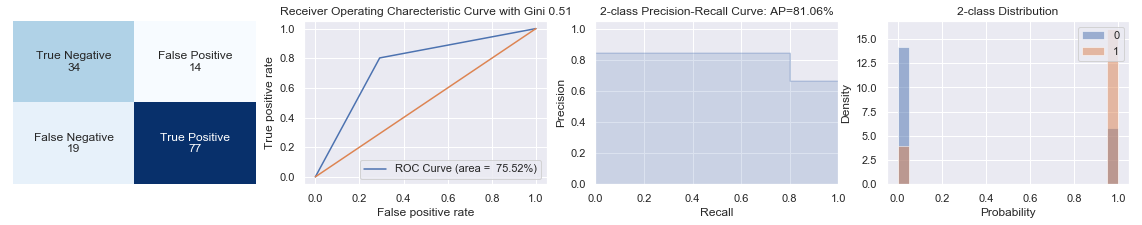

In [9]:
#%% model-2: decision tree
from sklearn.tree import DecisionTreeClassifier
model_dtree= DecisionTreeClassifier()
model_dtree.fit(X_train,y_train)
y_pred_model_dtree = model_dtree.predict(X_test)
y_prob_model_dtree = model_dtree.predict_proba(X_test)
print("\nDecision tree")
print("="*20)
acc,pc,rc,fs,ap,roc_auc,gini,prd = print_classification_performance2class_report(model_dtree,X_test,y_test)

In [10]:
i+=1
list_model.append('Model_{}'.format(i))
list_desc.append('Word Proportion /w Decision Tree')
list_acc.append(acc)
list_pc.append(pc)
list_rc.append(rc)
list_fs.append(fs)
list_ap.append(ap)
list_roc_auc.append(roc_auc)
list_gini.append(gini)

<p><font color="red"><b>Random Forest</b></font>


Random Forest
Accuracy:78.47%
Precision:76.42%
Recall:97.92%
Fscore:85.84%
Average precision:76.22%


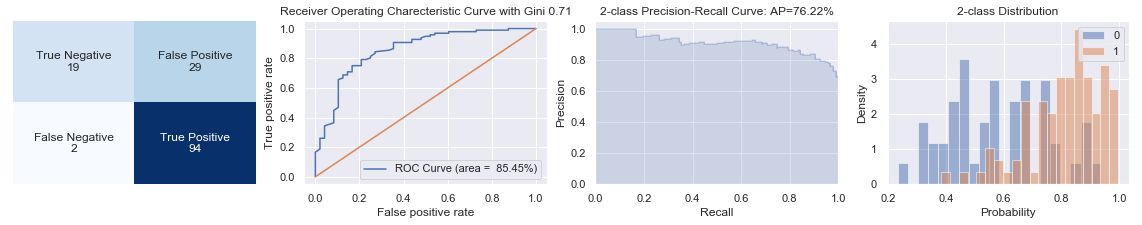

In [11]:
from sklearn.ensemble import RandomForestClassifier
model_forest = RandomForestClassifier(n_estimators=300)
model_forest.fit(X_train, y_train)
y_pred_model_forest = model_forest.predict(X_test)
print("\nRandom Forest")
print("="*20)
acc,pc,rc,fs,ap,roc_auc,gini,prd =print_classification_performance2class_report(model_forest,X_test,y_test)

In [12]:
i+=1
list_model.append('Model_{}'.format(i))
list_desc.append('Word Proportion /w Random Forest')
list_acc.append(acc)
list_pc.append(pc)
list_rc.append(rc)
list_fs.append(fs)
list_ap.append(ap)
list_roc_auc.append(roc_auc)
list_gini.append(gini)

<font face="Verdana, cursive, sans-serif">
<h1><b><center>Approach 2 Shorthand Programming </center></b></h1>

<b>Feature matrix : TF-IDF</b>

In this section, we demonstrate how to accomplish the whole process by using Python libraries, with Pipeline and without Pipeline functionality.



<font face="Verdana, cursive, sans-serif">
<b>Rebuild the data and import additional libraries</b>

In [13]:
#%% rebuild  data
news = pd.read_csv("./input/rtnews_topstory_labeled.csv",sep="|")
news['fulltext'] = news['title']+news['body']
news = news.drop_duplicates(subset=['fulltext'],keep='last')
news = news[(news['label']==1) | (news['label']==0) ]
goodnews = news[news['label']==1]['fulltext'].tolist()
badnews = news[news['label']==0]['fulltext'].tolist()

#split train and test data set
msg_train, msg_test, label_train, label_test = train_test_split(news['fulltext'], news['label'], test_size=0.2, random_state=1234, stratify = news['label'])

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

<font face="Verdana, cursive, sans-serif">
<p><b>Create model *with out* Pipeline functionality</b>
<p>Suppose we would like to build sentiment analyzer with naive_bayes model. There are 2 steps to perform as follows:-
<ol>
<li>Fit and transform sentences to feature matrix</li>
<li>Fit the model with the data</li> 
</ol>

In [14]:
#1.Fit and transform sentences to feature matrix
bow_transformer = CountVectorizer(analyzer=text_preprocess_tokenizer).fit(news['fulltext'])
messages_bow = bow_transformer.transform(news['fulltext'])
tfidf_transformer = TfidfTransformer().fit(messages_bow)
messages_tfidf = tfidf_transformer.transform(messages_bow)

#2.Fit the <naive_bayes> model with the data
from sklearn.naive_bayes import MultinomialNB

goodbad_model = MultinomialNB().fit(messages_tfidf, news['label'])
print("Model classification rate:{:.2%}".format(goodbad_model.score(messages_tfidf,news['label'])))

Model classification rate:77.96%


<font face="Verdana, cursive, sans-serif">
<p><b>Create model *with* Pipeline functionality</b>
<p> With pipline functionality, we can shorthen the program even futher
<p><font color="red"><b>Logistic Regression wiht TF-IDF feature matrix</b></font>


Pipeline - Bag of words/Tfidf -  LogisticRegression
Accuracy:75.69%
Precision:82.80%
Recall:80.21%
Fscore:81.48%
Average precision:79.60%


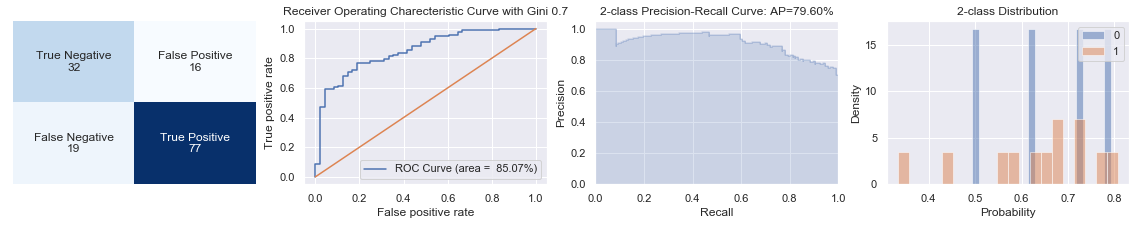

In [15]:

pipeline_logit = Pipeline([
        ('bow',CountVectorizer(analyzer=text_preprocess_tokenizer)),
        ('tfid',TfidfTransformer()),
        ('classifier',LogisticRegression(class_weight="balanced", solver='liblinear'))
        ])

pipeline_logit.fit(msg_train,label_train)
pred_logit = pipeline_logit.predict(msg_test)
print("\nPipeline - Bag of words/Tfidf -  LogisticRegression")
print("="*50)
acc,pc,rc,fs,ap,roc_auc,gini,prd = print_classification_performance2class_report(pipeline_logit,msg_test,label_test)

In [16]:
i+=1
list_model.append('Model_{}'.format(i))
list_desc.append('Tfidf /w LogisticRegression')
list_acc.append(acc)
list_pc.append(pc)
list_rc.append(rc)
list_fs.append(fs)
list_ap.append(ap)
list_roc_auc.append(roc_auc)
list_gini.append(gini)

<p><font color="red"><b>Decision Tree with TF-IDF feature matrix</b></font>


Pipeline - Bag of words/Tfidf -  Decision Tree
Accuracy:72.22%
Precision:78.57%
Recall:80.21%
Fscore:79.38%
Average precision:76.22%


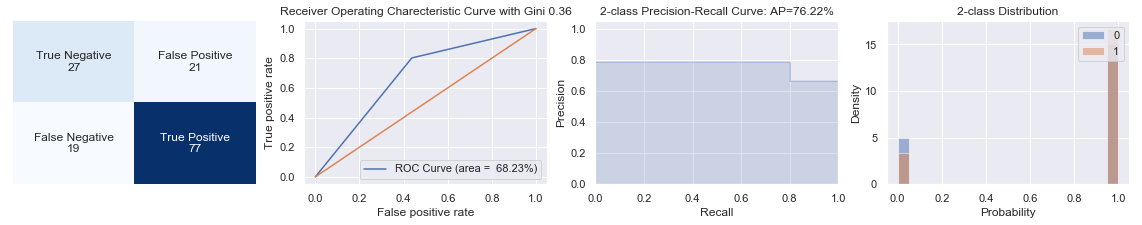

In [17]:
pipeline_dtree = Pipeline([
        ('bow',CountVectorizer(analyzer=text_preprocess_tokenizer)),
        ('tfid',TfidfTransformer()),
        ('classifier',DecisionTreeClassifier())
        ])

pipeline_dtree.fit(msg_train,label_train)
pred_dtree = pipeline_dtree.predict(msg_test)
print("\nPipeline - Bag of words/Tfidf -  Decision Tree")
print("="*50)
acc,pc,rc,fs,ap,roc_auc,gini,prd = print_classification_performance2class_report(pipeline_dtree,msg_test,label_test)

In [18]:
i+=1
list_model.append('Model_{}'.format(i))
list_desc.append('Tfidf /w Decision Tree')
list_acc.append(acc)
list_pc.append(pc)
list_rc.append(rc)
list_fs.append(fs)
list_ap.append(ap)
list_roc_auc.append(roc_auc)
list_gini.append(gini)

<p><font color="red"><b>Random Forest with TF-IDF feature matrix</b></font>


Pipeline - Bag of words/Tfidf -  RandomForestClassifier(n_estimators=300)
Accuracy:79.86%
Precision:78.15%
Recall:96.88%
Fscore:86.51%
Average precision:77.79%


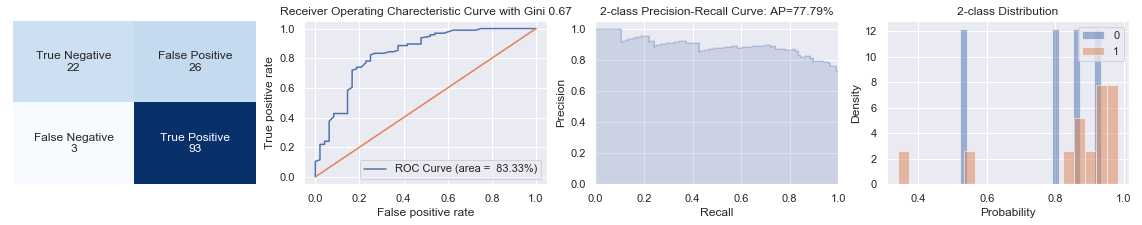

In [19]:
pipeline_forest = Pipeline([
        ('bow',CountVectorizer(analyzer=text_preprocess_tokenizer)),
        ('tfid',TfidfTransformer()),
        ('classifier',RandomForestClassifier(n_estimators=300))
        ])

pipeline_forest.fit(msg_train,label_train)
pred_forest = pipeline_forest.predict(msg_test)
print("\nPipeline - Bag of words/Tfidf -  RandomForestClassifier(n_estimators=300)")
print("="*50)
acc,pc,rc,fs,ap,roc_auc,gini,prd = print_classification_performance2class_report(pipeline_forest,msg_test,label_test)

In [20]:
i+=1
list_model.append('Model_{}'.format(i))
list_desc.append('Tfidf /w RandomForestClassifier')
list_acc.append(acc)
list_pc.append(pc)
list_rc.append(rc)
list_fs.append(fs)
list_ap.append(ap)
list_roc_auc.append(roc_auc)
list_gini.append(gini)

<font face="Verdana, cursive, sans-serif">
<p><b>Final Step - Score the data with models</b>

In [21]:
#%% score al models on the dataset

news = pd.read_csv("./input/rtnews_topstory_labeled.csv",sep="|")
news['fulltext'] = news['title']+news['body']
news = news.drop_duplicates(subset=['fulltext'],keep='last')

news['proba_logit']=pipeline_logit.predict_proba(news['fulltext'] )[:,1]
news['proba_forest']=pipeline_forest.predict_proba(news['fulltext'] )[:,1]

news = news.drop(['fulltext'] , axis=1)

outfile_path="./output/"
filename_final_csv=outfile_path+"_rtnews_sentiment_.csv"
news.to_csv(filename_final_csv,sep='|',index=False,encoding='utf-8-sig')

In [22]:
news[(news['label']==1)].head(5)

,label,id,ticker,date,title,body,proba_logit,proba_forest
10,1,23,ADVANC,11022017,Thai telecoms firm AIS's profits up on more su...,"BANGKOK, Nov 2 (Reuters) - Advance Info Servic...",0.575037,0.903333
18,1,31,ADVANC,2062017,BRIEF-Thai Advanced Info Pcl says believes int...,Feb 6 (Reuters) - Thai Advanced Info Pcl CEO S...,0.635187,0.983333
22,1,35,ADVANC,7042016,BRIEF-Advanced Info Service says AWN officiall...,"On 27 may 2016, Advanced Wireless Network Co.,...",0.578104,0.850000
29,1,42,ADVANC,2112016,BRIEF-Thai AIS aims 10 mln 4G subscribers by e...,The company aims 10 million 4G subscribers by ...,0.706463,1.000000
30,1,43,ADVANC,1262016,BRIEF-AIS,Jan 26 (Reuters) - Advanced Info Service Pcl C...,0.684134,0.943333


In [23]:
news[(news['label']==0)].head(5)

,label,id,ticker,date,title,body,proba_logit,proba_forest
0,0,3,ADVANC,6152018,BRIEF-Thai Telco Advanced Info Service Says Wi...,15-Jun-2018 12:44:35 - THAI MOBILE OPERATOR AD...,0.355465,0.286667
1,0,4,ADVANC,6152018,BRIEF-Advanced Info Service To Not Participate...,ADVANCED INFO SERVICE -NOT PARTICIPATING IN UP...,0.342022,0.270000
4,0,16,ADVANC,2052018,Thai telco Advanced Info Service announces 2 p...,"BANGKOK, Feb 5 (Reuters) - Thailand's largest ...",0.247953,0.320000
5,0,17,ADVANC,2052018,BRIEF-Advanced Info Service Posts FY Net Profi...,ADVANCED INFO SERVICE PCL - FY TOTAL REV 157.7...,0.406432,0.726667
33,0,46,ADVANC,3182015,"BUZZ-Thai AIS, Total Access retreat; key panel...",Advanced Info Service Pcl ADVANC.BK shares fal...,0.337226,0.203333


<font face="Verdana, cursive, sans-serif">
<p><b>Putting all metrics together for comparison</b>

In [24]:
compare = pd.DataFrame([list_model,list_desc,list_acc,list_pc,list_rc,list_fs,list_ap,list_roc_auc,list_gini]).transpose()
compare.columns=['model','description','accuracy','precision','recall','fscore','average_precision','auc','gini']
compare.set_index('model')

,description,accuracy,precision,recall,fscore,average_precision,auc,gini
model,,,,,,,,
Model_1,Word Proportion /w Logistic Regression,0.701389,0.784946,0.760417,0.772487,0.756608,0.759549,0.519097
Model_2,Word Proportion /w Decision Tree,0.770833,0.846154,0.802083,0.823529,0.81063,0.755208,0.510417
Model_3,Word Proportion /w Random Forest,0.784722,0.764228,0.979167,0.858447,0.762195,0.854492,0.708984
Model_4,Tfidf /w LogisticRegression,0.756944,0.827957,0.802083,0.814815,0.796035,0.850694,0.701389
Model_5,Tfidf /w Decision Tree,0.722222,0.785714,0.802083,0.793814,0.762153,0.682292,0.364583
Model_6,Tfidf /w RandomForestClassifier,0.798611,0.781513,0.96875,0.865116,0.777924,0.833333,0.666667


<font face="Verdana, cursive, sans-serif" >
<h1><center>Conclusion</center></h1>

The purpose of this program is to demonstrate basic steps of NLP. The above table summarise the performance of each model by each type of feature matrix. It is shown that TF-IDF with Random Forest etimating technique outperform all other models by approximately 10% - However, this demonstration is not with out major critigues on both data and methodology.


<b>Data Critiques</b>
<p>The most important part of this project is the reliability and credibility of the source of the data. We select Reuters news due to its reptutation of unbiasness. We label each news as good, bas, neutral based on its title and body content, which maybe subjective to the eyes of the readers. In total, we have only 1,914 news coverage of THAI stocks in SET50 index during 2014-2018/H1, more news from other local sources would have enhanced the robustnexs of the model </p>

<b>Modeling Critiques</b>
<p>As demonstrated in all models, the probability of news being 1 (good news) or 0 (bad news) are based on the features and labels, the more occurance of positive(negative) words, the higher proability of it being a good(bad) news. All three models do not take into account the importance of the relationship between each word. To futher this study, one would perform deep learning technique.</p>

